In [1]:
from collections import Counter
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

TRAIN_FILE = './data/train.csv'
TEST_FILE = './data/test.csv'

$$SMAPE_s = \frac{1}{6T_s} \sum_{t=1}^{T_s} \sum_{i=1}^{6} \frac{|p_{sti} - r_{sti}|}{|p_{sti}| + |r_{sti}|}$$
Where:
* $T_s$ -- number of measurements (timestamps) for satellite s
* $S$ -- total number of satellites
* $6$ -- total number of measured values (x, y, z, Vx, Vy, Vz) 
* $p_{sti}$ -- predicted value #$i$ of satellite $s$ in timestamp $t$
* $r_{sti}$ -- real value #$i$ of satellite $s$ in timestamp $t$

In [2]:
def calc_smape(lhs, rhs):
    return np.mean(np.abs((lhs - rhs) / (np.abs(lhs) + np.abs(rhs))))

def calc_score(smapes):
    return 100 * (1 - np.mean(smapes))

In [3]:
train_data = pd.read_csv(TRAIN_FILE, parse_dates=['epoch'])
test_data = pd.read_csv(TEST_FILE, parse_dates=['epoch'])
train_data.head()

,id,epoch,sat_id,x,y,z,Vx,Vy,Vz,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
0,0,2014-01-01 00:00:00.000,0,-8855.823863,13117.780146,-20728.353233,-0.908303,-3.808436,-2.022083,-8843.131454,13138.221690,-20741.615306,-0.907527,-3.804930,-2.024133
1,1,2014-01-01 00:46:43.000,0,-10567.672384,1619.746066,-24451.813271,-0.302590,-4.272617,-0.612796,-10555.500066,1649.289367,-24473.089556,-0.303704,-4.269816,-0.616468
2,2,2014-01-01 01:33:26.001,0,-10578.684043,-10180.467460,-24238.280949,0.277435,-4.047522,0.723155,-10571.858472,-10145.939908,-24271.169776,0.274880,-4.046788,0.718768
3,3,2014-01-01 02:20:09.001,0,-9148.251857,-20651.437460,-20720.381279,0.715600,-3.373762,1.722115,-9149.620794,-20618.200201,-20765.019094,0.712437,-3.375202,1.718306
4,4,2014-01-01 03:06:52.002,0,-6719.092336,-28929.061629,-14938.907967,0.992507,-2.519732,2.344703,-6729.358857,-28902.271436,-14992.399986,0.989382,-2.522618,2.342237


In [4]:
per_sat_scores = []
for _, data in train_data.groupby('sat_id'):
    smapes = calc_smape(data[['x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim']].values,
                        data[['x', 'y', 'z', 'Vx', 'Vy', 'Vz']].values)
    per_sat_scores.append(smapes)
per_sat_scores = np.array(per_sat_scores)
calc_score(per_sat_scores)

84.90976860742092

In [5]:
per_sat_time_diff = dict()

for sat_id, data in train_data.groupby('sat_id'):
    times = data.epoch.values
    per_sat_time_diff[sat_id] = list(zip(times[1:] - times[0:-1], times[1:]))

# Plots

In [6]:
def extract_per_ts_smapes(df, sat_id):
    smapes = []
    data = df[df['sat_id'] == sat_id].sort_values(by='epoch')
    reals = data[['x', 'y', 'z', 'Vx', 'Vy', 'Vz']].values
    sims = data[['x_sim', 'y_sim', 'z_sim', 'Vx_sim', 'Vy_sim', 'Vz_sim']].values
    for real, sim in zip(reals, sims):
        smapes.append(calc_smape(sim.reshape(1, -1), real.reshape(1, -1)))
    return np.array(smapes) / data.shape[0]

0.21350395752043982

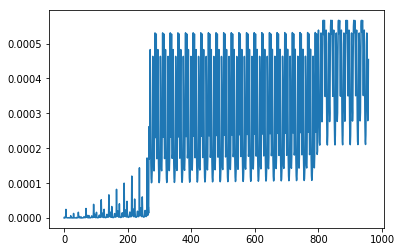

In [7]:
smapes = extract_per_ts_smapes(train_data, 0)
plt.plot(smapes)
smapes.sum()

0.13642182025204888

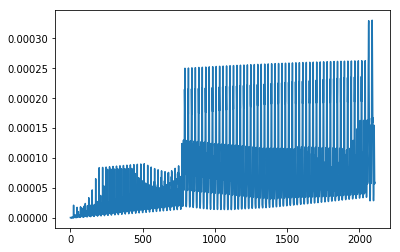

In [9]:
smapes = extract_per_ts_smapes(train_data, 1)
plt.plot(smapes)
smapes.sum()

0.15682678619533677

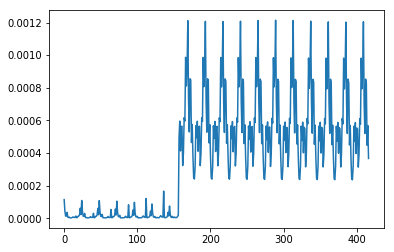

In [10]:
smapes = extract_per_ts_smapes(train_data, 2)
plt.plot(smapes)
smapes.sum()

0.21350395752043982

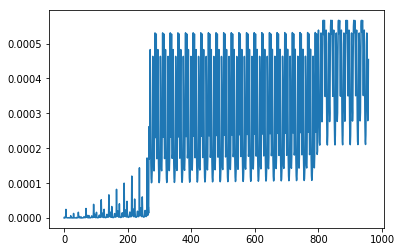

In [11]:
smapes = extract_per_ts_smapes(train_data, 0)
plt.plot(smapes)
smapes.sum()

In [12]:
def find_timestamp_anomaly(df, sat_id, anomaly_count_threshold=10):
    data = df[df.sat_id == sat_id].epoch.values
    deltas = data[1:] - data[0:-1]
    deltas_counter = Counter(deltas)
    anomaly_ts_ids = []
    for i, delta in enumerate(deltas):
        if deltas_counter[delta] <= anomaly_count_threshold:
            anomaly_ts_ids.append(i + 1)
    return np.array(anomaly_ts_ids)

Text(0,0.5,'absolute diff')

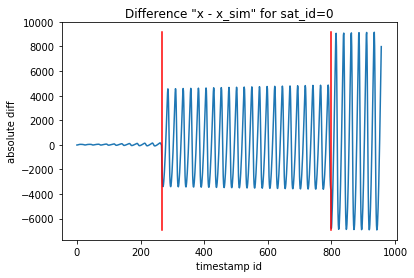

In [13]:
VAL = 'x'
SAT_ID = 0

sat_data = train_data[train_data.sat_id == SAT_ID]
anomaly_ts_ids = find_timestamp_anomaly(train_data, SAT_ID)
real_val = sat_data[VAL].values
sim_val = sat_data[VAL + '_sim'].values
val_diff = real_val - sim_val
min_diff, max_diff = val_diff.min(), val_diff.max()

plt.plot(val_diff)
plt.title(f'Difference "{VAL} - {VAL}_sim" for sat_id={SAT_ID}')
for ts_id in anomaly_ts_ids:
    plt.plot([ts_id, ts_id], [min_diff, max_diff], c='r')
plt.xlabel('timestamp id')
plt.ylabel('absolute diff')

In [24]:
x = train_data[train_data.sat_id == 0]
Counter(x.epoch.values[1:] - x.epoch.values[:-1])

Counter({numpy.timedelta64(2803000000000,'ns'): 481,
         numpy.timedelta64(2803001000000,'ns'): 474,
         numpy.timedelta64(1000000,'ns'): 2})

Text(0,0.5,'absolute diff')

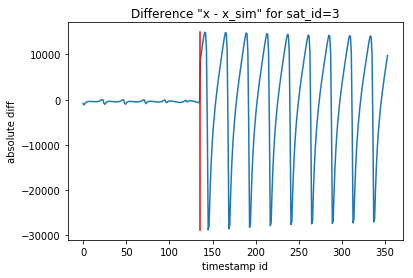

In [14]:
VAL = 'x'
SAT_ID = 3

sat_data = train_data[train_data.sat_id == SAT_ID]
anomaly_ts_ids = find_timestamp_anomaly(train_data, SAT_ID)
real_val = sat_data[VAL].values
sim_val = sat_data[VAL + '_sim'].values
val_diff = real_val - sim_val
min_diff, max_diff = val_diff.min(), val_diff.max()

plt.plot(val_diff)
plt.title(f'Difference "{VAL} - {VAL}_sim" for sat_id={SAT_ID}')
for ts_id in anomaly_ts_ids:
    plt.plot([ts_id, ts_id], [min_diff, max_diff], c='r')
plt.xlabel('timestamp id')
plt.ylabel('absolute diff')

# DOING STUPID STUFF

In [4]:
test_data.head()

,id,sat_id,epoch,x_sim,y_sim,z_sim,Vx_sim,Vy_sim,Vz_sim
0,3927,1,2014-02-01 00:01:45.162,-13366.891347,-14236.753503,6386.774555,4.333815,-0.692764,0.810774
1,3928,1,2014-02-01 00:22:57.007,-7370.434039,-14498.771520,7130.411325,5.077413,0.360609,0.313402
2,3929,1,2014-02-01 00:44:08.852,-572.068654,-13065.289498,7033.794876,5.519106,2.012830,-0.539412
3,3930,1,2014-02-01 01:05:20.697,6208.945257,-9076.852425,5548.296900,4.849212,4.338955,-1.869600
4,3931,1,2014-02-01 01:26:32.542,10768.200284,-2199.706707,2272.014862,1.940505,6.192887,-3.167724


In [7]:
stupid_data = pd.DataFrame(test_data)
stupid_data.columns = ['id', 'sat_d', 'epoch', 'x', 'y', 'z', 'Vx', 'Vy', 'Vz']
stupid_data = stupid_data[['id', 'x', 'y', 'z', 'Vx', 'Vy', 'Vz']]
stupid_data.to_csv('./predictions/stupid_prediction.csv', index=False)